### **Import Libraries**

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

### **Settings**

In [17]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20

data_dir = r"C:\1projects ml\Real-Time Face Mask Detector"


### **Data Generators**

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    classes=["with_mask", "without_mask"]
)

val_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    classes=["with_mask", "without_mask"]
)

num_classes = len(train_gen.class_indices)
class_names = list(train_gen.class_indices.keys())
print(f"Classes: {class_names}")


Found 252 images belonging to 2 classes.
Found 62 images belonging to 2 classes.
Classes: ['with_mask', 'without_mask']


### **Build EfficientNetB0 Model**

In [19]:
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### **Callbacks**

In [20]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.4, patience=2),
    ModelCheckpoint("efficientnet_mask_detector.h5", monitor="val_accuracy", save_best_only=True)
]


### **Train the Model**

In [21]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.6237 - loss: 0.6545

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 906ms/step - accuracy: 0.6508 - loss: 0.6453 - val_accuracy: 0.6613 - val_loss: 0.6440 - learning_rate: 1.0000e-04
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 608ms/step - accuracy: 0.6508 - loss: 0.6474 - val_accuracy: 0.6613 - val_loss: 0.6399 - learning_rate: 1.0000e-04
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 543ms/step - accuracy: 0.6548 - loss: 0.6499 - val_accuracy: 0.6613 - val_loss: 0.6398 - learning_rate: 1.0000e-04
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 549ms/step - accuracy: 0.6548 - loss: 0.6356 - val_accuracy: 0.6613 - val_loss: 0.6398 - learning_rate: 1.0000e-04
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 541ms/step - accuracy: 0.6548 - loss: 0.6536 - val_accuracy: 0.6613 - val_loss: 0.6398 - learning_rate: 1.0000e-04
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 574ms/step - accuracy: 0.6548 - loss: 0.6466 - val_accuracy: 0.6613 - val_loss: 0.6396 - learning_rate: 4.0000e-05
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 570ms/step - accuracy: 0.6627 - loss: 0.6529 - 

### **Plot Training Curves**

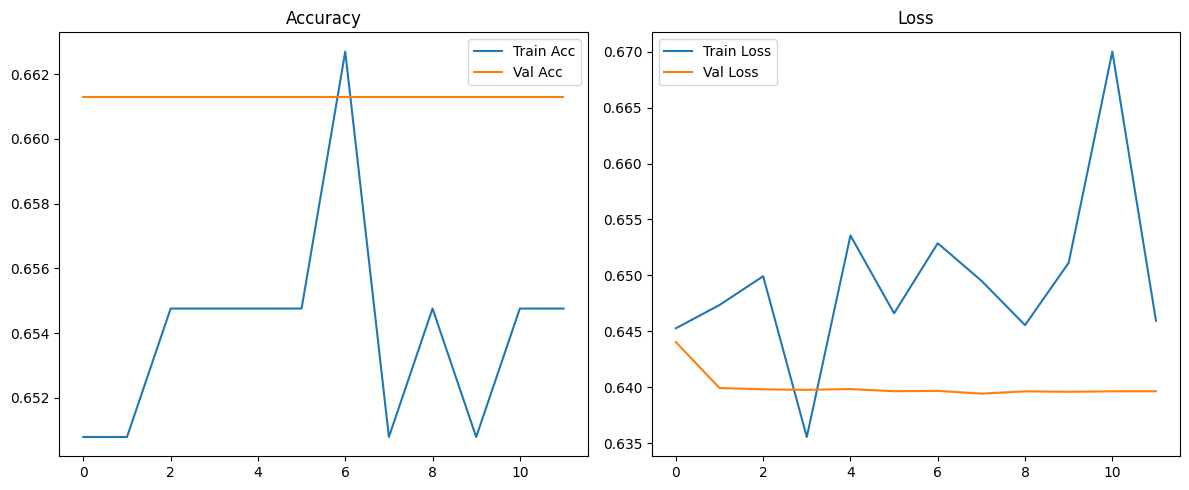

In [22]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

### **Fine-Tuning**

In [23]:
print("\nStarting fine-tuning...")
base_model.trainable = True
for layer in base_model.layers[:200]:
    layer.trainable = False
model.compile(
    optimizer=Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)


Starting fine-tuning...
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 838ms/step - accuracy: 0.4762 - loss: 0.7101 - val_accuracy: 0.6613 - val_loss: 0.6397 - learning_rate: 1.0000e-05
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 584ms/step - accuracy: 0.5913 - loss: 0.6936 - val_accuracy: 0.6613 - val_loss: 0.6398 - learning_rate: 1.0000e-05
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 587ms/step - accuracy: 0.6190 - loss: 0.6712 - val_accuracy: 0.6613 - val_loss: 0.6401 - learning_rate: 4.0000e-06
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 597ms/step - accuracy: 0.6310 - loss: 0.6613 - val_accuracy: 0.6613 - val_loss: 0.6404 - learning_rate: 4.0000e-06


### **Save Final Model**

In [24]:
model.save("mask_detector_final.h5")
model.save("mask_detector_final.keras")
print("\n[OK] Models saved.")


[OK] Models saved.


### **Single Image Prediction**

Selected file: C:/1projects ml/Real-Time Face Mask Detector/with_mask/with_mask_12.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: with_mask | Confidence: 65.40%


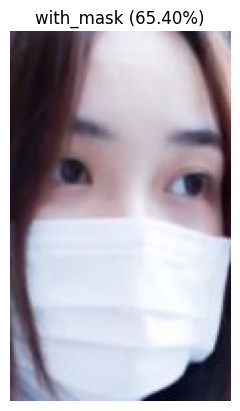

In [25]:
import tkinter as tk
from tkinter import filedialog

def open_file_and_predict():
    root = tk.Tk()
    root.withdraw()

    file_path = filedialog.askopenfilename(
        title="Select Image",
        filetypes=[("Image Files", "*.jpg *.jpeg *.png *.bmp")]
    )

    if not file_path:
        print("No file selected.")
        return

    print("Selected file:", file_path)
    predict_mask(file_path)

open_file_and_predict()
